# Shanghai Rental Price Prediction
  
###### By Eden Wu, Sara Han, Jacky Xu
  


---
## Menu
  
0. [__Preparations__](#prepare)  
    0.1. Importing Packages  
    0.2. Load Datas (After Cleaning)  
1. [__Feature Engineering__](#feature)  
    1.1. Scale Variables  
    1.2. Feature Importance Evaluation  
    1.3. Extracting Weak Features  
2. [__Modeling & Evaluation__](#model)  
    2.1. Roughly Estimate  
    2.2. Hyperparameters Tuning   
3. [__Ensemble__](#ensemble)  
    3.1. Weighted Average  
    3.2. Stacking  
  
  
---
  

<a id='prepare'></a>
## 0. __Preparations__
   ### 0.1 Importing Packages
   
   ***
   For this project we basically use sklearn package for machine learning.

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import skew
from sklearn.decomposition import PCA, KernelPCA

from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge

pd.set_option('max_colwidth',200)
pd.set_option('display.width',200)
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',1000)
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')


### 0.2 Load Datas
  
  ***
  We load datas from train and test. Concat them since we are using Cross Validation for all of our cases. Then load our validation dataset. The size of each dataset are listed below. Those are the datasets from data preprocessing. For details you can go to data_preprocessing.ipynb.

In [2]:
full=pd.read_excel('data/train.xls')
full = full.loc[:, ~full.columns.str.contains('^Unnamed')]
print("Train shape: ", full.shape)
full.head()

Train shape:  (15309, 155)


,Price,Area,Bedrooms,Livingrooms,Bathrooms,Floor,NextToSubway,Exquisite,OpenForVisits,Longitude,Latitude,863098207ffffff,86309820fffffff,863098217ffffff,86309821fffffff,863098227ffffff,86309822fffffff,863098237ffffff,863098247ffffff,86309824fffffff,863098257ffffff,86309825fffffff,863098267ffffff,86309826fffffff,863098277ffffff,863098287ffffff,86309828fffffff,863098297ffffff,86309829fffffff,8630982afffffff,8630982c7ffffff,8630982cfffffff,8630982d7ffffff,8630982dfffffff,8630982e7ffffff,8630982efffffff,8630982f7ffffff,863098307ffffff,863098347ffffff,86309834fffffff,863098357ffffff,86309835fffffff,86309836fffffff,86309838fffffff,8630983afffffff,86309864fffffff,863098657ffffff,863098667ffffff,86309874fffffff,863098967ffffff,863098c57ffffff,863099407ffffff,86309940fffffff,863099417ffffff,86309941fffffff,863099427ffffff,863099437ffffff,863099487ffffff,86309948fffffff,863099497ffffff,86309949fffffff,8630994a7ffffff,8630994afffffff,8630994b7ffffff,8630994c7ffffff,8630994cfffffff,8630994d7ffffff,8630994dfffffff,8630994e7ffffff,8630994efffffff,8630994f7ffffff,863099507ffffff,863099517ffffff,86309951fffffff,863099527ffffff,863099537ffffff,863099587ffffff,86309958fffffff,863099597ffffff,86309959fffffff,8630995a7ffffff,8630995afffffff,8630995b7ffffff,863099c27ffffff,863099c87ffffff,863099c97ffffff,863099c9fffffff,86309aa67ffffff,86309b117ffffff,86309b147ffffff,86309b167ffffff,86309b177ffffff,86309b807ffffff,86309b80fffffff,86309b827ffffff,86309b82fffffff,86309b837ffffff,86309b847ffffff,86309b84fffffff,86309b857ffffff,86309b85fffffff,86309b867ffffff,86309b86fffffff,86309b877ffffff,86309b89fffffff,86309b8a7ffffff,86309b8afffffff,86309b8c7ffffff,86309b8cfffffff,86309b8efffffff,86309b907ffffff,86309b90fffffff,86309b917ffffff,86309b91fffffff,86309b927ffffff,86309b92fffffff,86309b937ffffff,86309b947ffffff,86309b94fffffff,86309b957ffffff,86309b95fffffff,86309b967ffffff,86309b96fffffff,86309b977ffffff,86309b99fffffff,86309b9afffffff,86309ba0fffffff,86309ba17ffffff,86309ba27ffffff,86309ba2fffffff,86309ba57ffffff,86309ba8fffffff,86309bacfffffff,86309badfffffff,86309baf7ffffff,86309bb07ffffff,86309bb0fffffff,86309bb17ffffff,86309bb1fffffff,86309bb27ffffff,86309bb37ffffff,86309bb57ffffff,86309bb77ffffff,86309bb8fffffff,86309bb9fffffff,86309bba7ffffff,86309bbb7ffffff,86309bc4fffffff,86309bc67ffffff,86309bd6fffffff,86309d68fffffff,86318c74fffffff,86401970fffffff,864118b27ffffff,864189057ffffff
0,14000,152.0,4,2,2,3,0,0,0,121.645761,31.102990,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,12000,70.0,2,1,1,18,1,0,0,121.530920,31.238452,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,12000,71.0,2,1,1,18,1,0,0,121.530920,31.238452,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,16000,280.0,7,2,3,3,0,1,0,121.320695,31.183145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,7000,178.0,3,3,2,3,1,0,1,121.425749,31.040681,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0

<AxesSubplot:xlabel='Area', ylabel='Price'>

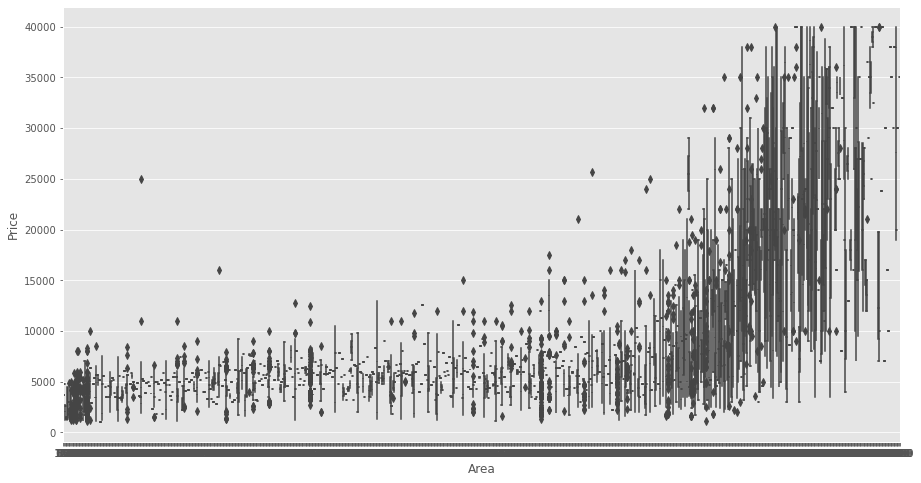

In [3]:
plt.figure(figsize=(15,8))
sns.boxplot(full["Area"], full["Price"])

<a id='feature'></a>
## 1. __Feature Selection__
### 1.1 Scale Variables

***
We then extract features and prices from our training dataset. Using scaler to scale our features since our features have very different scales which may degrade our model porfermance.Using StandardScaler can rescales the dataset such that all feature values are in Standard Distribution. Which will make our training easier! 

In [38]:
from sklearn.model_selection import train_test_split

X = full.drop(columns = ["Price"])
y = full["Price"]

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
#scaler = MinMaxScaler()
#scaler = RobustScaler()
scaler = StandardScaler()

X_scaled = scaler.fit(X).transform(X)
y_log = np.log(y)

### 1.2 Feature Importance Evaluation  
***  
We then use Lasso Regression to get the effective of different features to the Price. The learnable or trainable parameters in our models are θ0, θ1, …, θn. We then drop the features with lower effectivity. In this case, we drop features with a absolute theta under 200.


In [6]:
pd.options.display.float_format = '{:,.5f}'.format
lasso=Lasso(alpha=0.001)
lasso.fit(X_scaled,y)
from sklearn.tree import DecisionTreeRegressor
#tree=DecisionTreeRegressor()
#tree.fit(X_scaled,y)
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=X.columns)
FI_lasso.sort_values("Feature Importance",ascending=False)
#FI_tree = pd.DataFrame({"Feature Importance":tree.feature_importances_}, index=X.columns)
#FI_tree.sort_values("Feature Importance",ascending=False)

,Feature Importance
Latitude,"7,071.55010"
Area,"6,091.25892"
8630994b7ffffff,"2,568.81250"
86309bb07ffffff,"2,221.18785"
Floor,"1,854.37859"
8630994afffffff,"1,317.68515"
864118b27ffffff,992.67795
8630994a7ffffff,965.01657
Bedrooms,945.88760
Exquisite,806.64472


### 1.3 Extracting Weak Features


In [7]:
X_new = X.drop(columns=FI_lasso.index[abs(FI_lasso['Feature Importance'])<200])

X_new.shape

(15309, 103)

In [39]:
validate=pd.read_excel('data/validate.xls')
validate_y = validate["Price"]
validate_X=validate[X_new.columns]
print("Validation shape: ", validate.shape)
y.shape

Validation shape:  (3828, 156)


(15309,)

In [9]:
#scaler = MinMaxScaler()
#scaler = RobustScaler()

scaler = StandardScaler()

X_scaled = scaler.fit(X_new).transform(X_new)
y_log = np.log(y)

validate_X_scaled = scaler.fit(validate_X).transform(validate_X)

<a id='model'></a>
## 2. __Modeling & Evaluation__
### 2.1 Roughly Estimate  
***  
We are using MAE to evaluate different model performances since we are dealing with rental price, MAE will be more direct than RMSE. And Cross Validation are used to make better evaluations.

In [10]:
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

def mae_cv(model,X,y):
    mae = -cross_val_score(model, X, y, scoring="neg_mean_absolute_error", cv=5)
    return mae

The models for first estimations are: Linear Regression, Ridge Regression, Lasso Regression, Random Forest, Gradient Boosting Regression, Linear SVR, ElasticNet(NN), Bayesian Ridge Regression, Kernel Ridge Regression, and Extra Trees Regressor. We are going to do a default estimation for all of the models and get models with greatest performances.

In [11]:
models = [LinearRegression(),
          Ridge(),
          Lasso(),
          RandomForestRegressor(),
          GradientBoostingRegressor(),
          LinearSVR(),
          ElasticNet(),
          BayesianRidge(),
          KernelRidge(),
          ExtraTreesRegressor()]
names = ["LR", "Ridge", "Lasso", "RF", "GBR","LinSVR", "Ela","Bay","Ker","Extra"]

In [40]:
from sklearn.metrics import mean_absolute_error
y_mean = np.mean(y)
print("Linear_0_dim:",mean_absolute_error(y*0+y_mean,y))
validate_y_mean = np.mean(validate_y)
print("Validate_Linear_0_dim:",mean_absolute_error(validate_y*0+validate_y_mean,validate_y))


Linear_0_dim: 7271.534253075434
Validate_Linear_0_dim: 7126.616399646666


In [13]:
for name, model in zip(names, models):
    score = mae_cv(model, X_scaled, y)
    print("{}: {:.4f}, {:.4f}".format(name,score.mean(),score.std()))

LR: 525916618708288.1875, 646015192935278.7500
Ridge: 2242.8508, 43.6712
Lasso: 2240.5546, 41.7462
RF: 449.2122, 14.9803
GBR: 912.1451, 34.1537
LinSVR: 3606.9860, 98.4335
Ela: 2786.1311, 30.7877
Bay: 2241.1807, 41.6203
Ker: 38585.1890, 7200.8677
Extra: 435.8684, 33.9099


### 2.2 Hyperparameters Tuning  
***  
We can see that the greatest models are: Random Forest, GBR, Kernel Ridge, and Extra Forest. Hence we are going to do some fine-tuning to those selected models.

In [14]:
from scipy.stats import randint 
from scipy.stats import uniform
class grid():
    def __init__(self,model):
        self.model = model
    
    def grid_get(self,X,y,param_grid):
        grid_search = GridSearchCV(self.model,
                                   param_grid,
                                   cv=5, 
                                   scoring="neg_mean_absolute_error")
        grid_search.fit(X,y)
        print(grid_search.best_params_, -grid_search.best_score_)
        grid_search.cv_results_['mean_test_score'] = -grid_search.cv_results_['mean_test_score']
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

class random():
    def __init__(self,model):
        self.model = model
    
    def random_get(self,X,y,param_random):
        random_search = RandomizedSearchCV(self.model, 
                                           param_random,
                                           cv=5,    
                                           n_iter=20,
                                           scoring='neg_mean_absolute_error')
        random_search.fit(X,y)
        print(random_search.best_params_, -random_search.best_score_)
        random_search.cv_results_['mean_test_score'] = -random_search.cv_results_['mean_test_score']
        print(pd.DataFrame(random_search.cv_results_)[['params','mean_test_score','std_test_score']])

In [16]:
random(RandomForestRegressor()).random_get(X_scaled,y,{'n_estimators':randint(1,100)})

{'n_estimators': 94} 447.27227013828826
                  params  mean_test_score  std_test_score
0   {'n_estimators': 45}        454.51834        14.79634
1   {'n_estimators': 45}        452.21670        22.39670
2   {'n_estimators': 52}        451.91580        18.44883
3   {'n_estimators': 15}        461.08579        20.09937
4   {'n_estimators': 79}        453.47708        19.08366
5   {'n_estimators': 55}        451.46583        15.71531
6   {'n_estimators': 97}        449.78493        17.04065
7   {'n_estimators': 50}        455.19623        19.04647
8   {'n_estimators': 87}        450.99533        19.17335
9   {'n_estimators': 51}        454.49515        18.58368
10  {'n_estimators': 95}        454.40688        18.72496
11  {'n_estimators': 80}        451.56415        19.87593
12  {'n_estimators': 70}        451.70597        16.46807
13  {'n_estimators': 83}        453.50545        15.15267
14  {'n_estimators': 58}        450.61318        18.77969
15  {'n_estimators': 41}        

In [20]:
random(GradientBoostingRegressor()).random_get(X_scaled,y,{'n_estimators':randint(1000,5000),
                                                       'subsample':uniform(0,1),
                                                       'learning_rate':[0.05,0.1]
                                                      })

{'learning_rate': 0.1, 'n_estimators': 3928, 'subsample': 0.9204611494292558} 470.405193135417
                                                                             params  mean_test_score  std_test_score
0   {'learning_rate': 0.1, 'n_estimators': 2130, 'subsample': 0.019083729661466986}        995.52722        28.89614
1     {'learning_rate': 0.1, 'n_estimators': 4559, 'subsample': 0.7529060865175596}        470.91998        12.07152
2    {'learning_rate': 0.1, 'n_estimators': 3704, 'subsample': 0.34927051957677624}        504.12285        18.79529
3     {'learning_rate': 0.1, 'n_estimators': 4085, 'subsample': 0.5419606289571136}        479.72021        12.58534
4     {'learning_rate': 0.1, 'n_estimators': 3038, 'subsample': 0.8675097076079987}        476.76089        15.41245
5     {'learning_rate': 0.1, 'n_estimators': 2309, 'subsample': 0.1103540705866034}        663.49238        22.58496
6     {'learning_rate': 0.1, 'n_estimators': 1897, 'subsample': 0.9888380155234877}   

In [18]:
random(ExtraTreesRegressor()).random_get(X_scaled,y,{'n_estimators':randint(1,100)})

{'n_estimators': 58} 432.9852489140646
                  params  mean_test_score  std_test_score
0   {'n_estimators': 21}        444.85415        28.63014
1   {'n_estimators': 45}        438.33479        34.06123
2   {'n_estimators': 46}        440.45333        37.36076
3   {'n_estimators': 20}        444.15340        45.78012
4   {'n_estimators': 97}        436.71581        35.05782
5   {'n_estimators': 62}        438.10393        33.65385
6   {'n_estimators': 61}        436.18256        31.64616
7   {'n_estimators': 68}        438.92301        33.65618
8   {'n_estimators': 77}        435.13395        36.06819
9   {'n_estimators': 10}        453.24060        34.47980
10  {'n_estimators': 15}        450.76859        38.87327
11  {'n_estimators': 31}        439.86886        37.17892
12  {'n_estimators': 81}        438.26121        36.00079
13  {'n_estimators': 41}        435.65935        35.62613
14  {'n_estimators': 87}        435.86012        32.71019
15  {'n_estimators': 75}        4

In [19]:
param_rand={'alpha':uniform(0,1), 'kernel':["polynomial"], 'degree':[3],'coef0':uniform(0,1)}
random(KernelRidge()).random_get(X_scaled,y,param_rand)

{'alpha': 0.0902165307531746, 'coef0': 0.21773836223628384, 'degree': 3, 'kernel': 'polynomial'} 882.2156297760021
                                                                                                params  mean_test_score  std_test_score
0     {'alpha': 0.0902165307531746, 'coef0': 0.21773836223628384, 'degree': 3, 'kernel': 'polynomial'}        882.21563        98.95609
1      {'alpha': 0.6283683248460089, 'coef0': 0.7407005304774851, 'degree': 3, 'kernel': 'polynomial'}      1,069.94867       259.14537
2     {'alpha': 0.21075406560487564, 'coef0': 0.9870310582043219, 'degree': 3, 'kernel': 'polynomial'}        999.63390       251.57160
3    {'alpha': 0.056409425571376515, 'coef0': 0.0718794604560462, 'degree': 3, 'kernel': 'polynomial'}      1,126.97721       354.76424
4       {'alpha': 0.780674688989012, 'coef0': 0.7868304391598853, 'degree': 3, 'kernel': 'polynomial'}      1,080.83419       252.49532
5      {'alpha': 0.8094279848296693, 'coef0': 0.7165324625320153, 'de

In [15]:
# Getting Tuned Models
RF = RandomForestRegressor(n_estimators=94)
GBR = GradientBoostingRegressor(learning_rate=0.1, n_estimators=3928, subsample=0.9204611494292558)
Extra = ExtraTreesRegressor(n_estimators=58)
Kernel = KernelRidge(alpha=0.0902165307531746, kernel="polynomial", degree=3, coef0=0.21773836223628384)

In [12]:
print("------------------------------ 1. RF -----------------------------------")
print("training set RF: ",mae_cv(RF,X_scaled,y).mean())
print("validation set RF: ",mae_cv(RF,validate_X_scaled,validate_y).mean())
print("------------------------------ 2. GBR ----------------------------------")
print("training set GBR: ",mae_cv(GBR,X_scaled,y).mean())
print("validation set GBR: ",mae_cv(GBR,validate_X_scaled,validate_y).mean())
print("------------------------------ 3. Extra --------------------------------")
print("training set Extra: ",mae_cv(Extra,X_scaled,y).mean())
print("validation set Extra: ",mae_cv(Extra,validate_X_scaled,validate_y).mean())
print("------------------------------ 4. Kernel -------------------------------")
print("training set Kernel: ",mae_cv(Kernel,X_scaled,y).mean())
print("validation set Kernel: ",mae_cv(Kernel,validate_X_scaled,validate_y).mean())

------------------------------ 1. RF -----------------------------------
training set RF:  449.66312671506677
validation set RF:  613.6222076123607
------------------------------ 2. GBR ----------------------------------
training set GBR:  474.6021463341457
validation set GBR:  636.9788093667827
------------------------------ 3. Extra --------------------------------
training set Extra:  436.7702666736015
validation set Extra:  594.9900671936673
------------------------------ 4. Kernel -------------------------------
training set Kernel:  882.2156297760021
validation set Kernel:  988.1927647393384


<a id='ensemble'></a>
## 3. __Ensemble Methods__
### 3.1. Weighted Average  
***  
Ensemble Methods are very important to model training and improving.  
The simplest ensemble is using Weighted Average method, that is, simply weighted and averaged the performance of each model. We can see that it is actually acted similarly to models we trained above.

In [13]:
class AverageWeight(BaseEstimator, RegressorMixin):
    def __init__(self,mod,weight):
        self.mod = mod
        self.weight = weight
        
    def fit(self,X,y):
        self.models_ = [clone(x) for x in self.mod]
        for model in self.models_:
            model.fit(X,y)
        return self
    
    def predict(self,X):
        w = list()
        pred = np.array([model.predict(X) for model in self.models_])
        # for every data point, single model prediction times weight, then add them together
        for data in range(pred.shape[1]):
            single = [pred[model,data]*weight for model,weight in zip(range(pred.shape[0]),self.weight)]
            w.append(np.sum(single))
        return w

In [14]:
# Initializing Weights
w_RF = 0.3
w_GBR = 0.2
w_Extra = 0.4
w_Kernel = 0.1

In [15]:
weight_avg = AverageWeight(mod = [RF, GBR, Extra, Kernel],weight=[w_RF,w_GBR,w_Extra,w_Kernel])

In [16]:
mae_cv(weight_avg,X_scaled,y),  mae_cv(weight_avg,X_scaled,y).mean()

(array([421.53299921, 501.42761353, 432.17491468, 440.74244214,
        440.98317702]),
 447.6757523111366)

In [17]:
validate=pd.read_excel('data/validate.xls')
validate_y = validate["Price"]
validate_X=validate[X_new.columns]

validate_X_scaled = scaler.fit(validate_X).transform(validate_X)

In [18]:
mae_cv(weight_avg,validate_X_scaled,validate_y),  mae_cv(weight_avg,validate_X_scaled,validate_y).mean()

(array([621.77692525, 525.23175802, 492.05576797, 663.97182544,
        624.72156242]),
 584.9163606412011)

### 3.2. Stacking  
***
We choose stacking method as an important ensemble method because of it is a strong method for result enhancing since we have 3 strong models (RF, Extra, and GBR)!  

We choose the models that we finetuned previously as the models of the first layer of stacking, and Linear Regression as our meta model to further train our results.  




In [16]:
class stacking(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,mod,meta_model):
        self.mod = mod
        self.meta_model = meta_model
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)
        
    def fit(self,X,y):
        self.saved_model = [list() for i in self.mod]
        oof_train = np.zeros((X.shape[0], len(self.mod)))
        
        for i,model in enumerate(self.mod):
            for train_index, val_index in self.kf.split(X,y):
                renew_model = clone(model)
                renew_model.fit(X[train_index], y[train_index])
                self.saved_model[i].append(renew_model)
                oof_train[val_index,i] = renew_model.predict(X[val_index])
        
        self.meta_model.fit(oof_train,y)
        return self
    
    def predict(self,X):
        whole_test = np.column_stack([np.column_stack(model.predict(X) for model in single_model).mean(axis=1) 
                                      for single_model in self.saved_model]) 
        return self.meta_model.predict(whole_test)

In [17]:
from sklearn.impute import SimpleImputer
a = SimpleImputer().fit_transform(X_scaled)
b = SimpleImputer().fit_transform(y.values.reshape(-1,1)).ravel()
stack_model = stacking(mod=[GBR, RF, Extra],meta_model=LinearRegression())
mae = mae_cv(stack_model,a,b)
print(mae)
print(mae.mean())

[406.4464125  457.40005208 429.92959472 436.02128455 422.2818562 ]
430.415840010097


__Let's try the stacking model on our validation set:__
* It works well also on our validation set. And it is more stable than Random Forest!  

In [20]:
c = SimpleImputer().fit_transform(validate_X_scaled)
d = SimpleImputer().fit_transform(validate_y.values.reshape(-1,1)).ravel()
mae = mae_cv(stack_model,c,d)
print(mae)
print(mae.mean())

[665.21051747 512.88216188 490.6930111  659.61286095 615.98631917]
588.876974111097


In [21]:
stack_model.fit(c,d)

stacking(meta_model=LinearRegression(),
         mod=[GradientBoostingRegressor(n_estimators=3928,
                                        subsample=0.9204611494292558),
              RandomForestRegressor(n_estimators=94),
              ExtraTreesRegressor(n_estimators=58)])

In [22]:
y_eg = stack_model.predict(SimpleImputer().fit_transform(validate_X_scaled))
y_va = list(validate_y)

#errors = []
#error = 0
count = 0
y_p = []
y_r = []
for i in range(len(y_eg)):
    if y_eg[i] != y_va[i]:
        #error += abs(y_eg[i] - y_va[i])
        count += 1
        #errors.append(abs(y_eg[i] - y_va[i]))
        y_p.append(y_eg[i])
        y_r.append(y_va[i])
        
#error /= count
#print(errors)
print(count)

3828


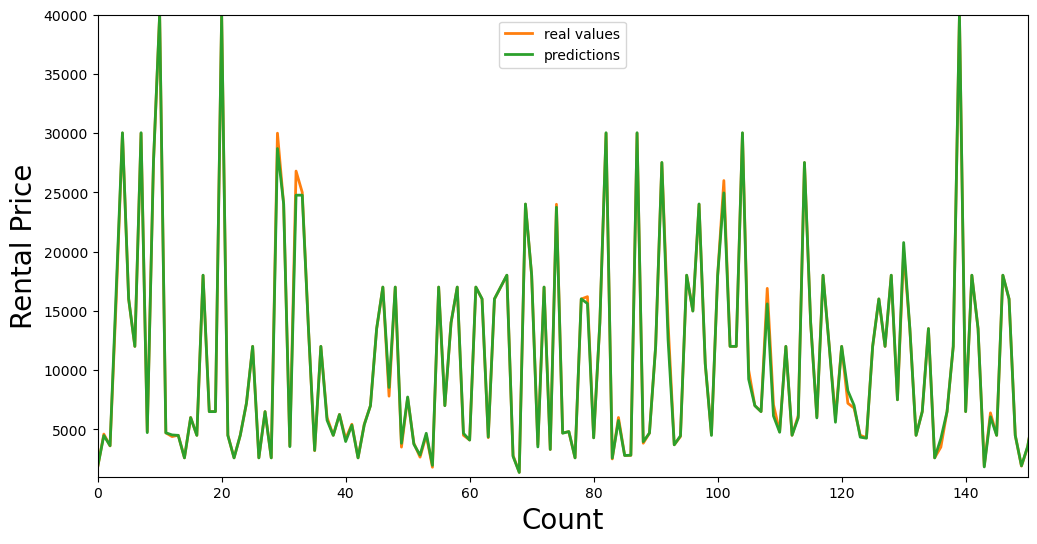

In [30]:
mpl.style.use('default')

plt.figure(figsize=(12, 6))
plt.plot(y_r,color='C1', label='real values',linewidth=2,alpha=1.0)
plt.plot(y_p,color='C2', label='predictions',linewidth=2,alpha=1.0)

plt.xlabel('Count',fontsize=20)
plt.ylabel('Rental Price',fontsize=20)
plt.xlim([0, 150])
plt.ylim([1000, 40000])
plt.legend()
plt.savefig("prediction.png")

In [26]:
models = [RandomForestRegressor(),
          GradientBoostingRegressor(),
          #KernelRidge(),
          ExtraTreesRegressor()]


In [27]:
y_egs = [] 
for model in models:
    model.fit(c,d)
    y_egs.append(model.predict(SimpleImputer().fit_transform(validate_X_scaled)))


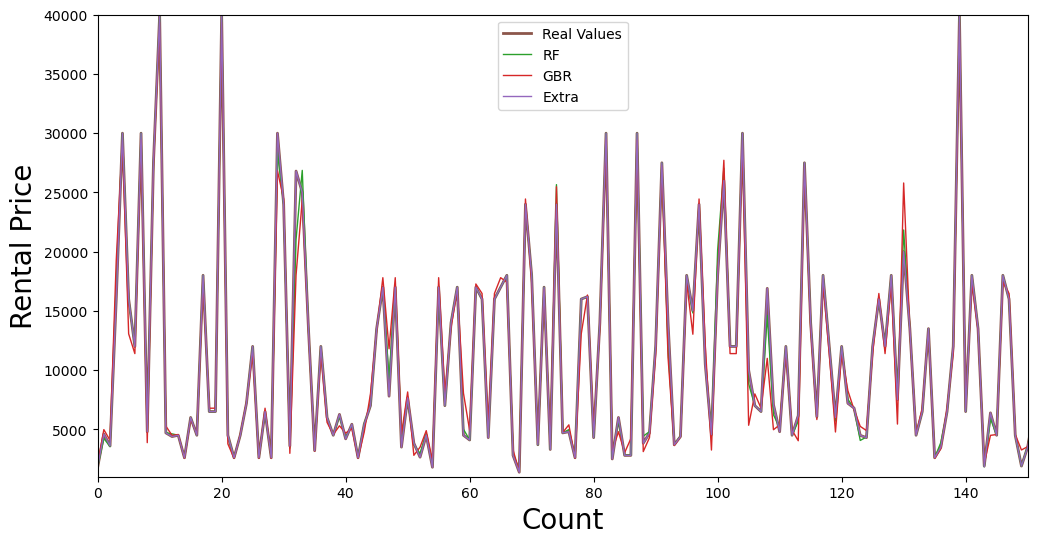

In [29]:
names = ["RF", "GBR","Extra"]
mpl.style.use('default')

plt.figure(figsize=(12, 6))
plt.plot(y_va,color='C5', label='Real Values',linewidth=2,alpha=1.0)
for index,y in enumerate(y_egs):
    plt.plot(y,color='C'+str(index+2), label=names[index],linewidth=1,alpha=1)



plt.xlabel('Count',fontsize=20)
plt.ylabel('Rental Price',fontsize=20)
plt.xlim([0, 150])
plt.ylim([1000, 40000])
plt.legend()
plt.savefig("before_prediction.png")